\# TEXTUAL DATA ANALYSIS Exercise 5

## SETUP


In [30]:
!pip3 -q install datasets transformers evaluate seqeval

### imports

In [31]:
import datasets
from pprint import pprint
import pandas as pd
import time
import transformers
from huggingface_hub import login
from google.colab import userdata
import matplotlib.pyplot as plt
import numpy as np

### settings...

In [32]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

### log in to hf

In [33]:
login(userdata.get('huggingface'))

### get some news texts

In [58]:
!wget http://dl.turkunlp.org/TKO_8964_2023/news-en-2021.jsonl

--2025-01-30 13:23:47--  http://dl.turkunlp.org/TKO_8964_2023/news-en-2021.jsonl
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3385882 (3.2M) [application/octet-stream]
Saving to: ‘news-en-2021.jsonl.2’

news-en-2021.jsonl. 100%[===================>]   3.23M  2.70MB/s    in 1.2s    

2025-01-30 13:23:48 (2.70 MB/s) - ‘news-en-2021.jsonl.2’ saved [3385882/3385882]



In [35]:
!head -n 1 news-en-2021.jsonl

{"summary": "The decisions follow a meeting of government ministers at the House of the Estates on Thursday afternoon.", "tags": ["Kotimaan uutiset"], "text": "Finland's government is pushing ahead with plans to introduce a Covid pass, following a meeting of ministers at the House of the Estates in Helsinki on Thursday afternoon. \n \"There are still many open questions that need to be answered. At this point, it is impossible to promise that the pass will come or when it will come,\" Prime Minister  Sanna Marin  (SDP) told the media following the conclusion of the meeting. \n \"The government has given the green light to the Covid pass and preparations will continue,\" Marin added. \n Minister of Economic Affairs  Mika Lintilä  (Cen) told reporters immediately after the meeting that there was broad agreement between the coalition parties over the need for the certificate. \n \"It [the pass] is an important tool so that we will not need restrictions any more,\" Lintilä said. \n The gov

In [36]:
dataset = datasets.load_dataset('json', data_files='news-en-2021.jsonl')

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'tags', 'text', 'timestamp', 'title', 'url'],
        num_rows: 1059
    })
})

In [38]:
articles = dataset['train']
only_texts = articles['text']

In [39]:
only_texts[0]

'Finland\'s government is pushing ahead with plans to introduce a Covid pass, following a meeting of ministers at the House of the Estates in Helsinki on Thursday afternoon. \n "There are still many open questions that need to be answered. At this point, it is impossible to promise that the pass will come or when it will come," Prime Minister  Sanna Marin  (SDP) told the media following the conclusion of the meeting. \n "The government has given the green light to the Covid pass and preparations will continue," Marin added. \n Minister of Economic Affairs  Mika Lintilä  (Cen) told reporters immediately after the meeting that there was broad agreement between the coalition parties over the need for the certificate. \n "It [the pass] is an important tool so that we will not need restrictions any more," Lintilä said. \n The government also decided at Thursday afternoon\'s meeting to offer coronavirus vaccines to all 12- to 15-year-olds, starting as early as next week. \n "Fortunately, we 

In [40]:
MODEL_NAME = "dslim/bert-base-NER"

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForTokenClassification.from_pretrained(MODEL_NAME)



# ignore_labels (List[str], defaults to ["O"]) — A list of labels to ignore.. ==> set to empty list to get "O" tags from https://huggingface.co/docs/transformers/v4.48.1/en/main_classes/pipelines#transformers.pipeline
nlp = transformers.pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="none",ignore_labels=[]) # includes subwords starting with "#"

# no need to use 'ignore_subwords'
# /usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:175: UserWarning: `ignore_subwords` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.NONE"` instead.


In [41]:
%%time

text_dict = {}

for i,o in enumerate(only_texts):
  ner_results = nlp(o)
  NER_LABELS = []

  for n in ner_results:
    if n['word'].startswith("#") and i == 0: # just to check subwords present
      print(n)
    NER_LABELS.append(n['entity'])

  text_dict[f'text {i+1}'] = NER_LABELS


{'entity': 'I-MISC', 'score': 0.8990488, 'index': 14, 'word': '##vid', 'start': 66, 'end': 69}
{'entity': 'B-PER', 'score': 0.89568216, 'index': 71, 'word': '##na', 'start': 346, 'end': 348}
{'entity': 'I-ORG', 'score': 0.9959787, 'index': 75, 'word': '##P', 'start': 359, 'end': 360}
{'entity': 'I-MISC', 'score': 0.8578796, 'index': 98, 'word': '##vid', 'start': 471, 'end': 474}
{'entity': 'B-PER', 'score': 0.90876216, 'index': 114, 'word': '##ka', 'start': 560, 'end': 562}
{'entity': 'I-PER', 'score': 0.9781991, 'index': 116, 'word': '##til', 'start': 566, 'end': 569}
{'entity': 'I-PER', 'score': 0.9961313, 'index': 117, 'word': '##ä', 'start': 569, 'end': 570}
{'entity': 'I-ORG', 'score': 0.97934693, 'index': 120, 'word': '##n', 'start': 575, 'end': 576}
{'entity': 'O', 'score': 0.6032715, 'index': 166, 'word': '##til', 'start': 809, 'end': 812}
{'entity': 'O', 'score': 0.8321557, 'index': 167, 'word': '##ä', 'start': 812, 'end': 813}
{'entity': 'O', 'score': 0.99915195, 'index': 183

## TASK 1

Read the model page to figure out which datasets were used to train the model, and which entities the model includes.

* The basemodel is trained with BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).
* The model was fine-tuned on English version of the standard CoNLL-2003 Named Entity Recognition dataset.

## TASK 2

Run inference on the news data, and verify whether the model produces invalid label sequences (hint: it does if you run on some amount of data). Here you do not need to take into account subwords to tokens -mapping, but you can directly check the label sequence of subwords (raw predictions). Print statistics for the most common invalid transitions. Hint: If you run the inference using pipeline, it may hide some of the predictions from you. Set the pipeline parameters so that you get access to raw predictions.

### algo

In [42]:
# invalid sequences
# 1: from Outside to Inside
# 2: from Inside to Begin
# 3: from Begin of entity to Inside of other entity

def check_invalid_sequence(source_labels:list) -> list:
  inv_list = []
  for i in range(1, len(source_labels)):
    curr_element = source_labels[i]
    prev_element = source_labels[i-1]
    if prev_element.startswith("O") and curr_element.startswith("I"): # 1
      print(prev_element, curr_element)
      inv_list.append(f'{prev_element} ==> {curr_element}')
    elif prev_element.startswith("I") and curr_element.startswith("B"): # 2, no O in between, i think this is valid rule?
      print(prev_element, curr_element)
      inv_list.append(f'{prev_element} ==> {curr_element}')
    elif (prev_element.startswith("B") and curr_element.startswith("I")) and  not (curr_element.endswith(prev_element[-3:])): # 3 this rules is for example B-PER ==> I-LOC transition, so 3 chars from end
      print(prev_element, curr_element)
      inv_list.append(f'{prev_element} ==> {curr_element}')
  return inv_list

In [43]:
len(text_dict)

1059

In [44]:
invalid_sequences = {}

print("working...")
for k,v in text_dict.items():
  invalids = check_invalid_sequence(v)

  for i in invalids:
    if i in invalid_sequences:
      invalid_sequences[i] += 1
    else:
      invalid_sequences[i] = 1
print("done!")

working...
O I-ORG
O I-MISC
O I-MISC
O I-ORG
I-LOC B-LOC
O I-MISC
O I-PER
O I-PER
O I-PER
O I-LOC
O I-PER
O I-PER
I-PER B-PER
B-LOC I-ORG
I-ORG B-PER
O I-LOC
O I-LOC
I-MISC B-LOC
B-PER I-ORG
I-LOC B-LOC
O I-MISC
I-ORG B-PER
I-ORG B-PER
O I-PER
O I-MISC
O I-PER
B-PER I-ORG
B-PER I-ORG
O I-ORG
O I-PER
B-MISC I-LOC
O I-MISC
O I-ORG
B-PER I-ORG
B-MISC I-ORG
O I-MISC
O I-MISC
I-PER B-PER
O I-MISC
B-MISC I-ORG
O I-MISC
O I-ORG
O I-ORG
B-ORG I-LOC
O I-ORG
O I-MISC
O I-PER
O I-PER
O I-PER
O I-ORG
I-ORG B-PER
O I-ORG
I-LOC B-LOC
B-MISC I-ORG
O I-MISC
O I-MISC
O I-ORG
B-ORG I-LOC
I-ORG B-PER
O I-PER
O I-PER
O I-PER
O I-PER
O I-ORG
B-ORG I-PER
O I-ORG
I-MISC B-LOC
B-PER I-ORG
O I-MISC
O I-MISC
O I-ORG
O I-PER
O I-PER
O I-PER
O I-PER
O I-ORG
O I-ORG
O I-PER
B-PER I-ORG
O I-PER
O I-PER
B-PER I-ORG
O I-PER
O I-PER
O I-ORG
O I-ORG
O I-ORG
O I-ORG
O I-ORG
O I-ORG
O I-ORG
O I-PER
O I-PER
O I-PER
O I-ORG
O I-MISC
O I-MISC
B-LOC I-ORG
B-MISC I-ORG
O I-MISC
O I-ORG
B-ORG I-LOC
I-LOC B-LOC
O I-PER
B-ORG I-

In [45]:
sort_by_occurance = dict(sorted(invalid_sequences.items(), key = lambda x: x[1], reverse=True))

for k, v in sort_by_occurance.items():
  print(f'{k:20}{v}')

O ==> I-ORG         381
O ==> I-PER         287
O ==> I-MISC        199
B-MISC ==> I-ORG    150
B-PER ==> I-ORG     100
O ==> I-LOC         76
I-ORG ==> B-PER     74
I-PER ==> B-PER     73
I-LOC ==> B-LOC     56
B-ORG ==> I-LOC     47
B-LOC ==> I-ORG     41
B-ORG ==> I-MISC    26
B-MISC ==> I-LOC    16
B-PER ==> I-LOC     13
B-ORG ==> I-PER     12
I-ORG ==> B-ORG     12
I-MISC ==> B-MISC   9
I-ORG ==> B-LOC     6
B-LOC ==> I-PER     4
B-LOC ==> I-MISC    4
I-MISC ==> B-LOC    3
I-ORG ==> B-MISC    3
I-LOC ==> B-PER     2
I-MISC ==> B-ORG    2
B-PER ==> I-MISC    2
I-PER ==> B-LOC     1
I-LOC ==> B-ORG     1


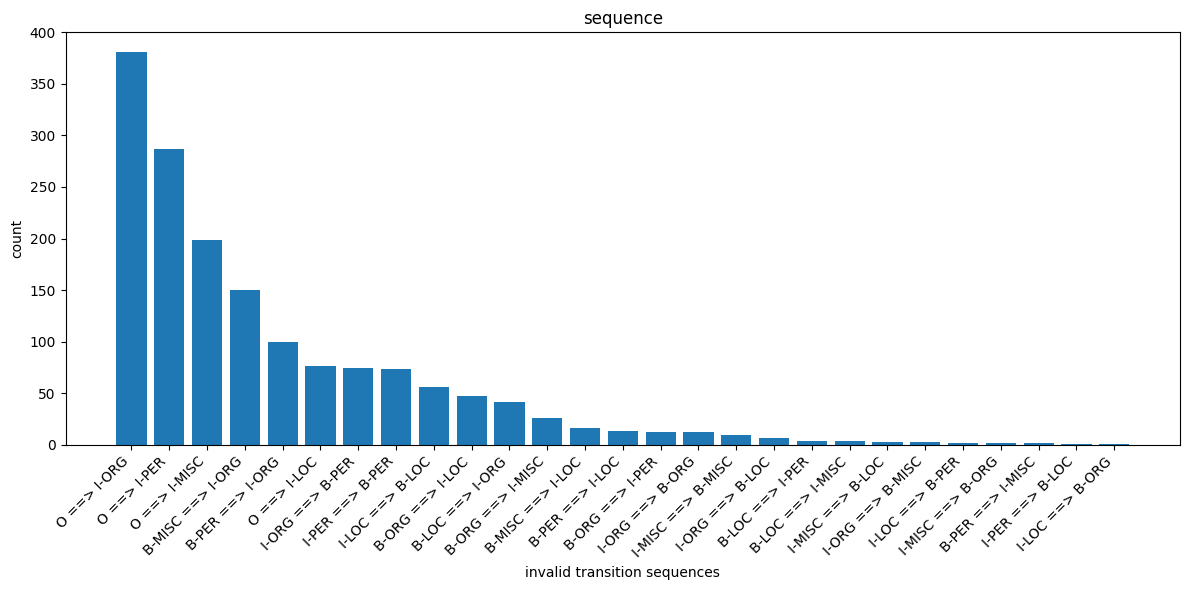

In [46]:
labels = []
values = []

for k,v in sort_by_occurance.items():
  labels.append(k)
  values.append(v)

plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("invalid transition sequences")
plt.ylabel("count")
plt.title("sequence")
plt.tight_layout()
plt.show()

## TASK 3

Read about the ´aggregation_strategy´ parameter for token classification pipelines (sometimes source code is the best place to get information...). Based on your reading, select a suitable parameter (or in case you run the inference without using pipelines, write a simple function to implement some simple aggregation strategy), run the inference, and collect predicted named entities. What is the most common entity type in your data and what are the most common entities?


In [47]:
# https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/token_classification.py
#
# if grouped_entities is not None or ignore_subwords is not None:
#            if grouped_entities and ignore_subwords:
#                aggregation_strategy = AggregationStrategy.FIRST
#
# both params will be removed in v5.0.0 but if both are True that means that we create grouped entities, i.e. omitting the B-, I-
# and ignore_subwords does not generate ## starting subword tokens
# AND without the ignore_labels (List[str], defaults to ["O"]) — we also omit the Outside tag

nlp = transformers.pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

In [48]:
%%time

NERS_dict = {}
ENTITIES_dict = {}

print("working...")
for i,o in enumerate(only_texts):
  if i % 50 == 0:
    print(f'working on text number: {i}')
  ner_results = nlp(o)
  NER_LABELS = []
  ENTITIES = []

  for n in ner_results:
    if n['word'].startswith("#") and i == 0: # just to check subwords present
      print(n)
    NER_LABELS.append(n['entity_group'])
    ENTITIES.append(n['word'])

  NERS_dict[f'text {i+1}'] = NER_LABELS
  ENTITIES_dict[f'text {i+1}'] = ENTITIES
print("done!")


working...
working on text number: 0
working on text number: 50
working on text number: 100
working on text number: 150
working on text number: 200
working on text number: 250
working on text number: 300
working on text number: 350
working on text number: 400
working on text number: 450
working on text number: 500
working on text number: 550
working on text number: 600
working on text number: 650
working on text number: 700
working on text number: 750
working on text number: 800
working on text number: 850
working on text number: 900
working on text number: 950
working on text number: 1000
working on text number: 1050
done!
CPU times: user 34.2 s, sys: 103 ms, total: 34.3 s
Wall time: 34.2 s


### Most common entity type

In [49]:
NERS_COUNTER = {}

for v in NERS_dict.values():
  for i in v:
    if i in NERS_COUNTER.keys():
      NERS_COUNTER[i] += 1
    else:
      NERS_COUNTER[i] = 1

In [50]:
sort_NERS_by_occurance = dict(sorted(NERS_COUNTER.items(), key = lambda x: x[1], reverse=True))

for k, v in sort_NERS_by_occurance.items():
  print(f'{k:20}{v}')

ORG                 8000
LOC                 6191
PER                 4581
MISC                3752


In [51]:
NERS_labels = []
NERS_values = []

for k,v in sort_NERS_by_occurance.items():
  NERS_labels.append(k)
  NERS_values.append(v)


### Most common entity

In [52]:
ENTITY_COUNTER = {}

for v in ENTITIES_dict.values():
  for i in v:
    if i in ENTITY_COUNTER.keys():
      ENTITY_COUNTER[i] += 1
    else:
      ENTITY_COUNTER[i] = 1

In [53]:
sort_ENTITY_by_occurance = dict(sorted(ENTITY_COUNTER.items(), key = lambda x: x[1], reverse=True))

for k, v in sort_ENTITY_by_occurance.items():
  if v > 50: # limit to above 50 occurances
    print(f'{k:20}{v}')

Finland             2285
Finnish             939
Covid               926
Helsinki            550
Yle                 543
THL                 291
EU                  256
Marin               204
Afghanistan         192
SDP                 170
Helsingin Sanomat   117
Tampere             114
Niinistö            106
Omicron             104
Russia              103
Finns Party         101
Kabul               99
HUS                 98
Sanna Marin         96
Uusimaa             92
HS                  90
Green               90
Haavisto            88
NCP                 82
Cen                 81
Sweden              81
Swedish             77
Iltalehti           77
Avi                 76
Russian             75
Finns               75
US                  75
Greens              70
Taliban             70
Lapland             68
Belarus             68
Ohisalo             65
Turku               63
Ministry of Social Affairs and Health61
Europe              59
Centre Party        55
European            54


In [54]:
ENTITY_labels = []
ENTITY_values = []

for k,v in sort_ENTITY_by_occurance.items():
  ENTITY_labels.append(k)
  ENTITY_values.append(v)


In [55]:
X_VALUES = [NERS_labels,ENTITY_labels[:20]] # limit to top 20
Y_VALUES = [NERS_values, ENTITY_values[:20]] # limit to top 20

In [56]:
X_VALUES

[['ORG', 'LOC', 'PER', 'MISC'],
 ['Finland',
  'Finnish',
  'Covid',
  'Helsinki',
  'Yle',
  'THL',
  'EU',
  'Marin',
  'Afghanistan',
  'SDP',
  'Helsingin Sanomat',
  'Tampere',
  'Niinistö',
  'Omicron',
  'Russia',
  'Finns Party',
  'Kabul',
  'HUS',
  'Sanna Marin',
  'Uusimaa']]

0
['ORG', 'LOC', 'PER', 'MISC']
1
['Finland', 'Finnish', 'Covid', 'Helsinki', 'Yle', 'THL', 'EU', 'Marin', 'Afghanistan', 'SDP', 'Helsingin Sanomat', 'Tampere', 'Niinistö', 'Omicron', 'Russia', 'Finns Party', 'Kabul', 'HUS', 'Sanna Marin', 'Uusimaa']


<ipython-input-57-a4923c6becdb>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = X_VALUES[i], rotation=45, ha="right")
<ipython-input-57-a4923c6becdb>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = X_VALUES[i], rotation=45, ha="right")


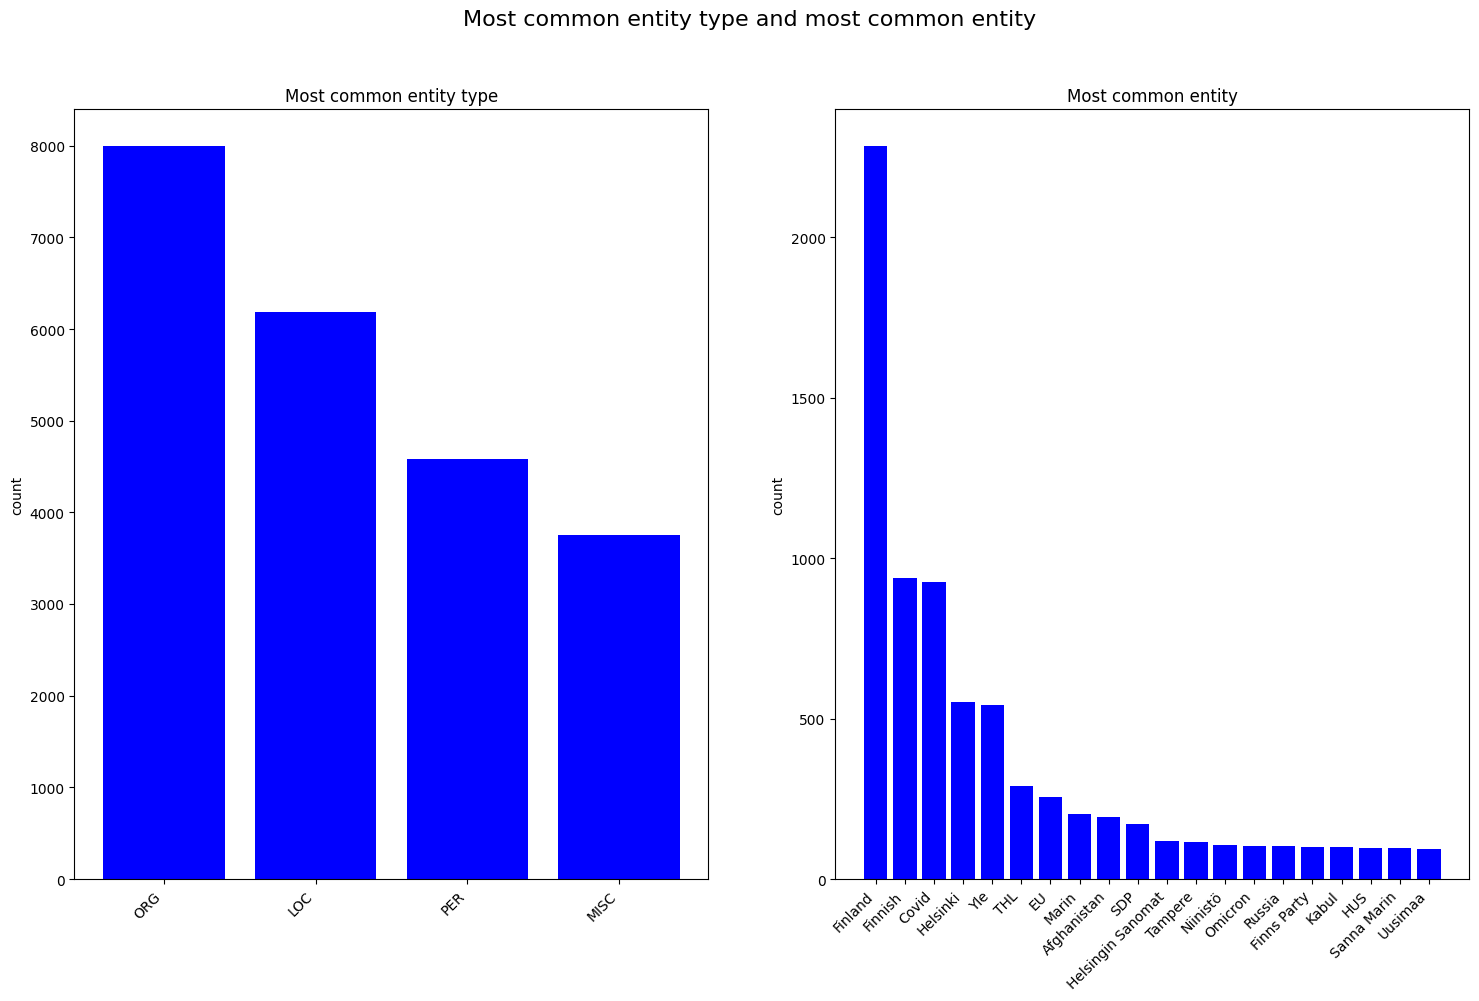

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle("Most common entity type and most common entity", fontsize=16)
titles = ['Most common entity type', "Most common entity"]

for i, ax in enumerate(axes):
  print(i)
  print(X_VALUES[i])
  ax.bar(X_VALUES[i], Y_VALUES[i], color='blue')
  ax.set_ylabel("count")
  ax.set_title(f'{titles[i]}')
  ax.set_xticklabels(labels = X_VALUES[i], rotation=45, ha="right")
plt.show()